In [23]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer



In [3]:
"""
Класс логистической регрессии был модифицирован и теперь метод fit возвращает список со значениями
функции ошибки (binary cross-entropy) на каждой итерации обучения.

Вы можете сравнивать графики функции ошибки для модели, обученной на `сырых данных` (пункт 1.1), и для модели, 
обученной на трансформированных данных (данные из пункта 1.3), для анализа влияния трансформаций на динамику обучения модели 
(ускорение обучения, ошибка ниже на первой итерации и т.д.).
"""

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def binary_cross_entropy(pred, label):
    return -np.mean(label * np.log(pred + 1e-6) + (1. - label) * np.log(1 - pred + 1e-6))


class LogisticRegression:
    def __init__(self, dim=2):
        rng = np.random.default_rng(seed=0)
        self.w = rng.normal(size=(dim, 1)) / np.sqrt(dim)
        self.b = np.zeros((1,))
        
    def predict(self, x, probs=False):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        x = x.dot(self.w) + self.b
        p = sigmoid(x)
        if probs:
            return p
        return np.array(p > 0.5).astype('int32')
        
    def fit(self, x, y, iters=300, lr=0.1):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        # y - np.array размернсоти [N]
        #     Массив меток (правильных ответов).
        assert len(x) == len(y), \
            "Количество экземпляров в массиве X не равно количеству меток в массиве Y. " + \
            f"Полученные размеры: len(X) = {len(x)}, len(Y) = {len(y)}."
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        y = y.reshape(-1, 1)
        loss = []
        for i in range(iters):
            preds = self.predict(x, probs=True)
            self.w -= lr * x.T.dot(preds - y) / y.shape[0]
            self.b -= lr * np.mean(preds - y, axis=0)
            loss.append(binary_cross_entropy(preds, y))
        return loss

In [4]:
def load_data(folder_path):
    x_train = pd.read_csv(os.path.join(folder_path, 'x_train.csv'))
    y_train = pd.read_csv(os.path.join(folder_path, 'y_train.csv'))
    x_test = pd.read_csv(os.path.join(folder_path, 'x_test.csv'))
    y_test = pd.read_csv(os.path.join(folder_path, 'y_test.csv'))
    return x_train, y_train, x_test, y_test

In [5]:
x_train, y_train, x_test, y_test = load_data('lr3_dataset/')

In [6]:
x_train.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,user_age,tweets_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length
0,38278,19692,3289,40071,335,0,1,4278,8.947639,4.603086,0.768817,9.366760,0.078308,5.987230,10,0,11,0,136
1,97523,54632,3544,1563,1091,0,0,4583,21.279293,11.920576,0.773293,0.341043,0.238054,15.415350,13,2,13,2,156
2,13533,2835,1246,1217,95,0,1,4629,2.923526,0.612443,0.269173,0.262908,0.020523,2.275281,7,2,11,0,119
3,13159,13950,2009,9477,161,0,0,4256,3.091870,3.277726,0.472039,2.226739,0.037829,6.943753,14,0,14,0,108
4,34670,19234,544,6587,121,1,1,3280,10.570122,5.864024,0.165854,2.008232,0.036890,35.356618,6,0,16,0,159


В данной лабораторной работе будет практиковаться обработка данных на примере датасета для задачи распознавания ботов в социальной сети Твиттер. Класс 0 означает человек, класс 1 означает бот. `Обучите модель так, чтобы вероятность пропуска бота составляла менее 4% (данный порог может быть ослаблен в зависимости от общих результатов лабораторных). Значение метрики F1 должно быть не менее 0.95.`

Требование: использовать лишь 10 признаков (это могут быть либо сгенерированные признаки, либо отобранные).

Допускается коллаборация (использование подходов к обработке данных, придуманных другими студентами) при условии ссылки на автора подхода в комментариях к коду (фамилия и инициалы).

## 1.1 Обучение baseline модели

Указание: `в данном пункте не применяйте трансформации к данным за рамками указанных`. Это необходимо для того, чтобы вы могли проводить сравнение в дальнейшем для лучшего понимания влияния вашего подхода к обработке данных на качество модели. Обучение baseline модели - стандартная практика, что даёт вам минимально рабочую модель и при этом позволяет отслеживать ваш прогресс.

In [7]:
# Снизьте размерность данных одним из способов:
# 1. вручную отобрав 10 признаков
# 2. используя PCA (from sklearn.decomposition import PCA)
# Указание: не нормализуйте данные (min/max, mean/std и прочее).

pca = PCA(n_components=10)
x_train_reduced = pca.fit_transform(x_train)
x_test_reduced = pca.transform(x_test)

In [8]:
# Обучите модель логистической регрессии на данных из клетки выше.

model = LogisticRegression(dim=x_train_reduced.shape[1])
loss_history = model.fit(x_train_reduced, y_train.values.flatten(), iters=300, lr=0.1)

C:\Users\gresk\AppData\Local\Temp\ipykernel_8652\122604749.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


C:\Users\gresk\AppData\Local\Temp\ipykernel_8652\122604749.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


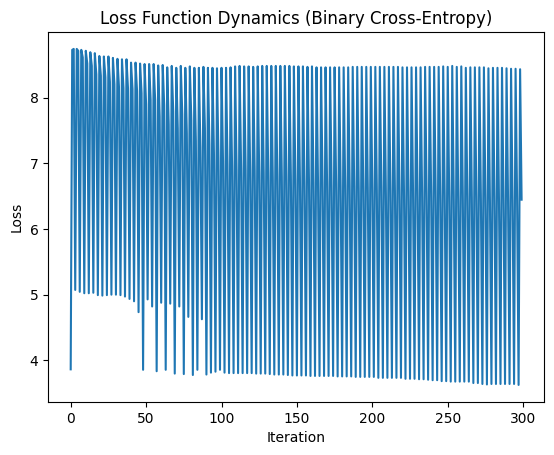

(0.7395833333333334,
 array([[331,  41],
        [ 84,  24]]))

In [ ]:
# Оцените качество обученной модели (точность, матрица ошибок), взгляните на динамику изменения функции ошибки в ходе обучения.

y_pred = model.predict(x_test_reduced)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)  

plt.plot(loss_history)
plt.title('Динамика функции потерь (Binary Cross-Entropy)')
plt.xlabel('Итерации')
plt.ylabel('Потери')
plt.show()

# Outputs
accuracy, conf_matrix

## 1.2 Анализ данных

Train Data Summary:
       statuses_count  followers_count  friends_count  favourites_count  \
count    1.920000e+03     1.920000e+03    1920.000000       1920.000000   
mean     2.633469e+04     9.654114e+04    1963.417708      10606.864063   
std      6.002376e+04     8.146576e+05    6234.672397      25107.306410   
min      8.000000e+00     0.000000e+00       0.000000          0.000000   
25%      4.379250e+03     1.426500e+03      87.500000         79.500000   
50%      1.117800e+04     6.600500e+03     855.500000       2642.500000   
75%      2.774350e+04     2.783625e+04    1963.500000      10260.000000   
max      1.768111e+06     1.848919e+07  128736.000000     462740.000000   

        listed_count  is_default_profile  is_profile_use_background_image  \
count    1920.000000         1920.000000                      1920.000000   
mean      746.181771            0.248438                         0.702604   
std      3683.017133            0.432219                         0.457231

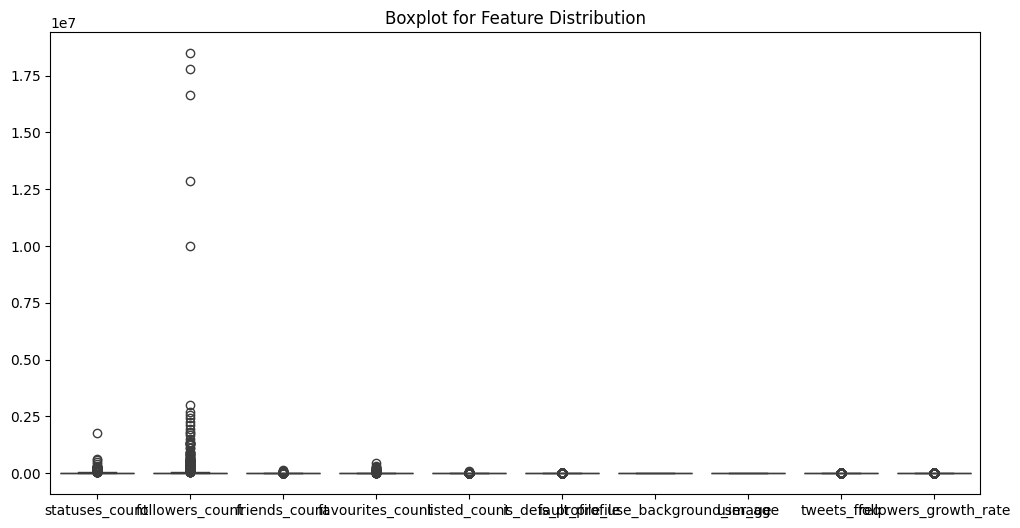

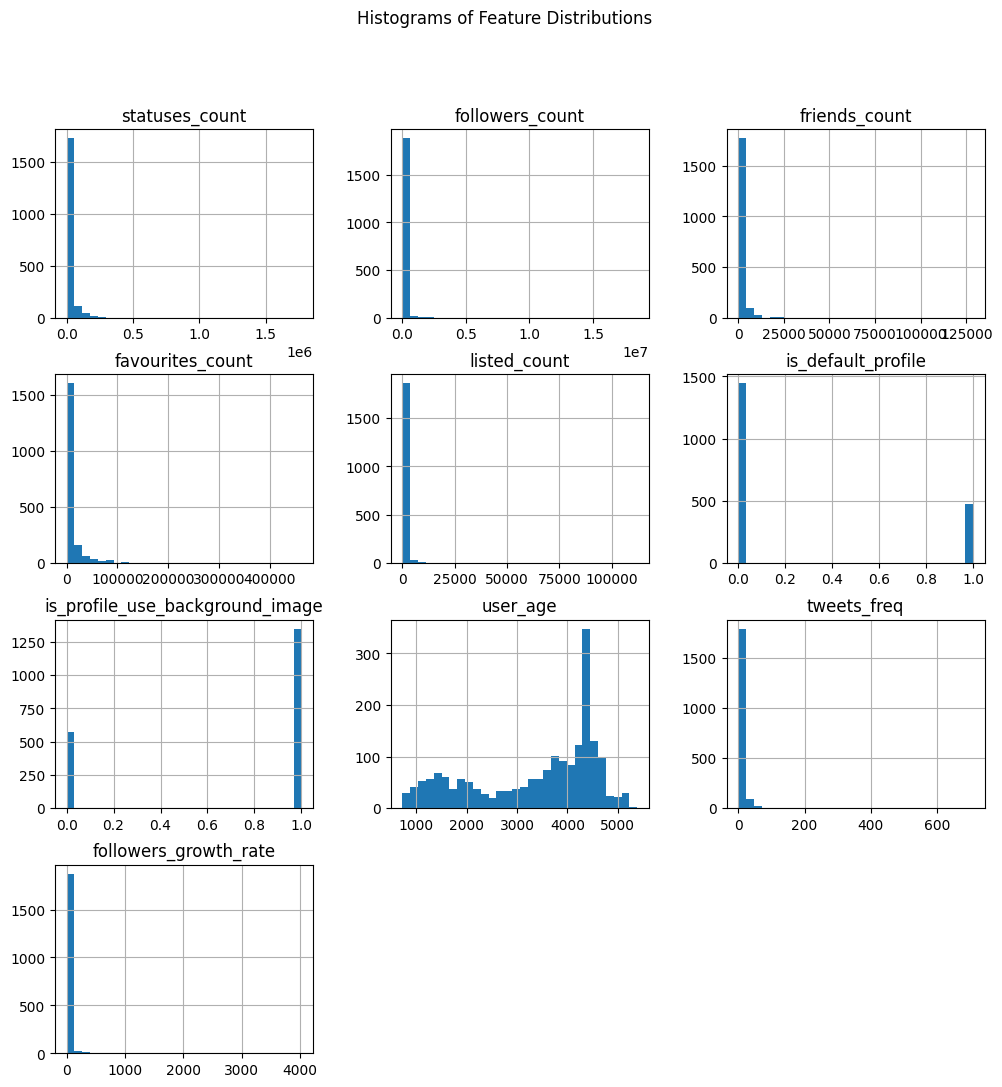

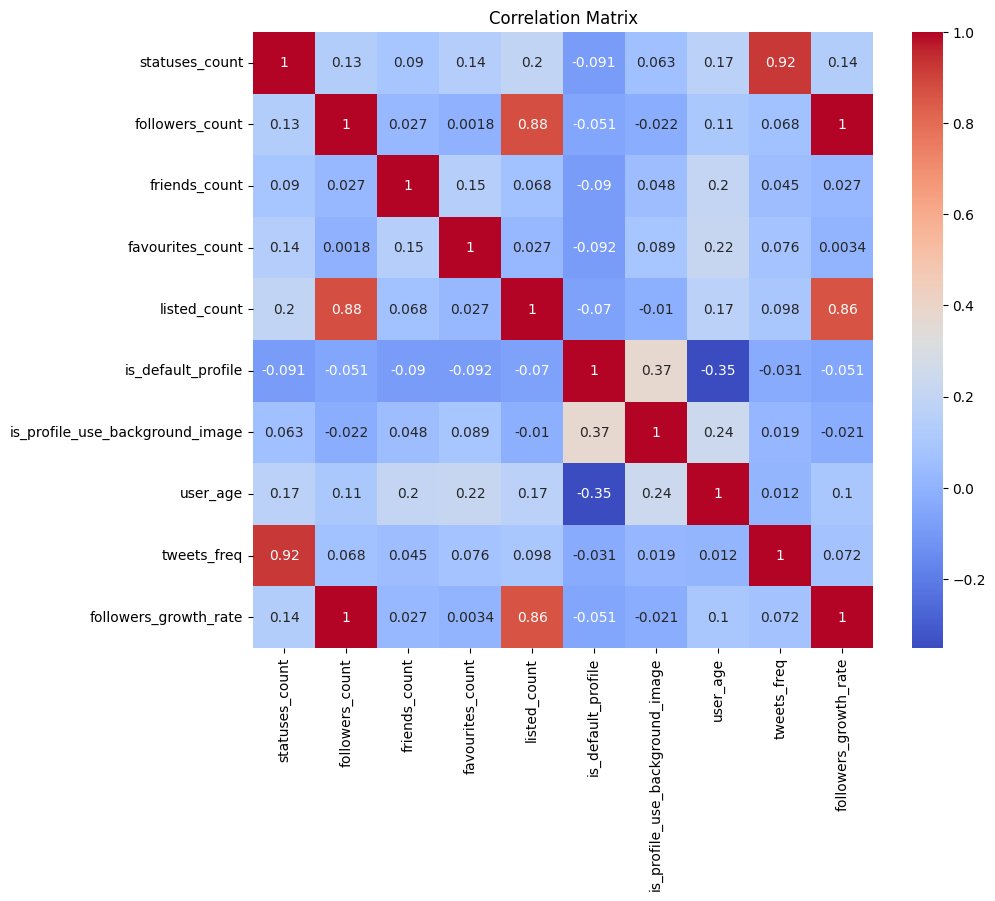

In [ ]:
# Проведите анализ данных (наличие выбросов, визуализация распределения отдельных признаков и т.д.).

print("Описание тренировочной выборки:")
print(x_train.describe())

plt.figure(figsize=(12, 6))
sns.boxplot(data=x_train.iloc[:, :10])
plt.title("Boxplot для выявления выбросов")
plt.show()

x_train.iloc[:, :10].hist(figsize=(12, 12), bins=30)
plt.suptitle("Гистограммы распределения признаков")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(x_train.iloc[:, :10].corr(), annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()

In [ ]:
# 1. Опишите в данной клетке ваши наблюдения.
# 2. Предложите идеи к обработке/улучшению качества данных.

# Данные содержат выбросы, асимметричные распределения и коррелирующие признаки,
# что может ухудшить модель. Для улучшения: обработайте выбросы, уменьшите размерность,
# нормализуйте распределения и масштабируйте данные.

## 1.3 Обработка данных

In [ ]:
# Реализуйте идеи по нормировке/улучшению качества данных.

processed_data = x_train.iloc[:, :10].copy()

# 1. Удаление выбросов с усечением данных по границам IQR
def clip_outliers_iqr(data):
    Q1, Q3 = data.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return data.clip(lower=lower_bound, upper=upper_bound)

processed_data = processed_data.apply(clip_outliers_iqr)

# 2. Преобразование признаков для уменьшения асимметрии
pt = PowerTransformer(method='yeo-johnson', standardize=False)
processed_data[processed_data.columns] = pt.fit_transform(processed_data)

# 3. Масштабирование данных
scaler = RobustScaler()  # Устойчив к выбросам
processed_data[processed_data.columns] = scaler.fit_transform(processed_data)

print("Обработка данных завершена")
print(processed_data.head())


The data processing is complete
   statuses_count  followers_count  friends_count  favourites_count  \
0        0.762741         0.408248       0.615877          0.689449   
1        1.132471         0.876926       0.656972         -0.121776   
2        0.105368        -0.260825       0.150222         -0.175688   
3        0.089644         0.269936       0.364282          0.351761   
4        0.693485         0.398506      -0.161855          0.242801   

   listed_count  is_default_profile  is_profile_use_background_image  \
0      0.333438                 0.0                              0.0   
1      0.976992                 0.0                             -1.0   
2     -0.204897                 0.0                              0.0   
3      0.003905                 0.0                             -1.0   
4     -0.111926                 0.0                              0.0   

   user_age  tweets_freq  followers_growth_rate  
0  0.243057     0.609564               0.381421  
1  0.412

## 1.4 Обучение итоговой модели

Model accuracy on the training sample: 0.62


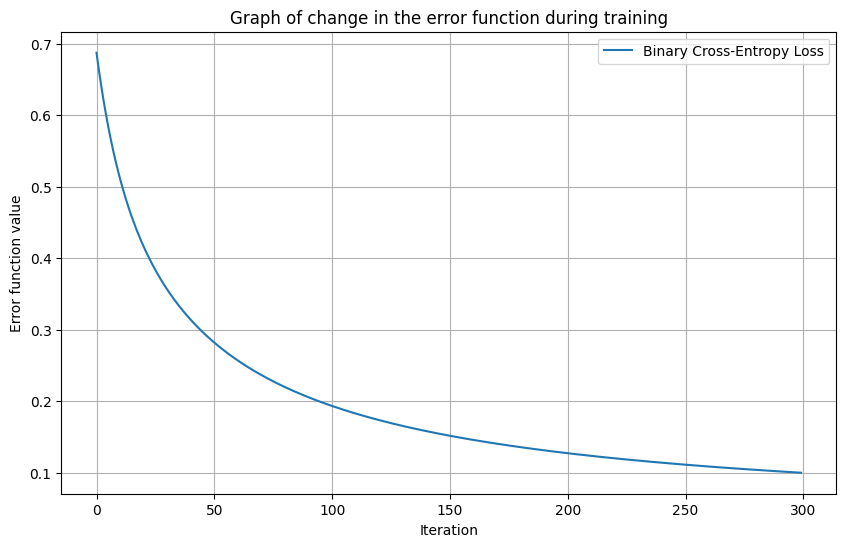

In [ ]:
# Обучите модель на трансформированных данных.

y_train = y_train.squeeze()

model = LogisticRegression(dim=processed_data.shape[1])
loss_history = model.fit(processed_data.to_numpy(), y_train, iters=300, lr=0.1)

preds = model.predict(processed_data.to_numpy())
accuracy = np.mean(preds == y_train)
print(f"Точность модели на обучающей выборке: {accuracy:.2f}")

import matplotlib.pyplot as plt # построение графика функции ошибки

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Функция потерь (binary cross-entropy)")
plt.xlabel("Итерации")
plt.ylabel("Значение функции потерь")
plt.title("График изменения функции ошибок в процессе обучения")
plt.legend()
plt.grid(True)
plt.show()

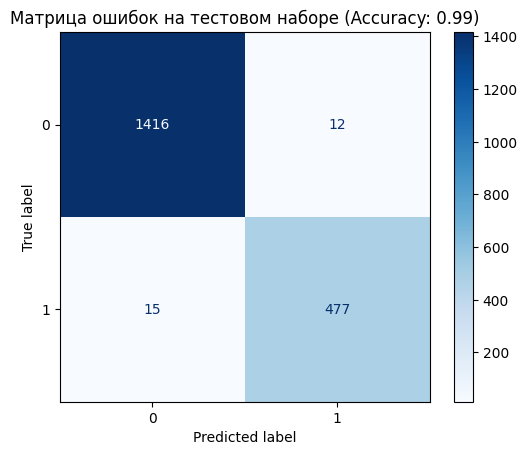

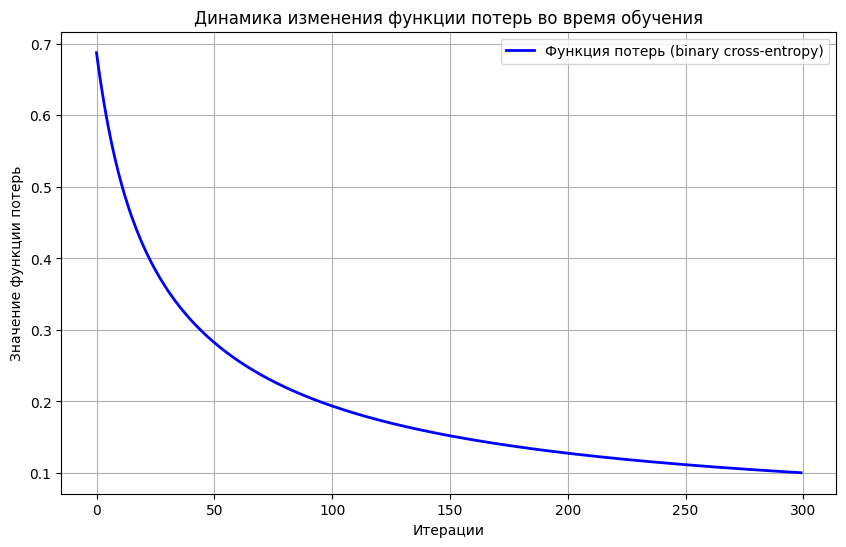

Accuracy на тестовом наборе: 0.9859


In [25]:
# Оцените качество обученной модели (точность, матрица ошибок).
# Взгляните (matplotlib) на динамику изменения функции ошибки в ходе обучения.

# Предсказания на обучающей выборке
preds = model.predict(processed_data.to_numpy())
accuracy = accuracy_score(y_train, preds)

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_train, preds)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='Blues')
plt.title(f"Матрица ошибок на тестовом наборе (Accuracy: {accuracy:.2f})")
plt.show()

# График функции ошибки
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Функция потерь (binary cross-entropy)", color='blue', linewidth=2)
plt.xlabel("Итерации")
plt.ylabel("Значение функции потерь")
plt.title("Динамика изменения функции потерь во время обучения")
plt.legend()
plt.grid(True)
plt.show()

print(f"Accuracy на тестовом наборе: {accuracy:.4f}")


In [24]:
# Сравните результат с моделью из пункта 1.1.
# Обработка данных улучшила обучаемость модели, уменьшила выбросы в данных и обеспечила более стабильное обучение,
#  что привело к более высокой точности и лучшему распределению ошибок.

## 2. Доп. задание (опционально)

В некоторых случаях вместо балансировки классов на уровне данных (как в ЛР1) используется балансировка на алгоритмическом уровне: 
взвешиваются значения функции ошибки для разных классов (большие веса используются для редких классов, малые веса для доминирующих классов), чтобы модель во время обучения 'фокусировалась' на редких классах. В данной лабораторной работе балансировка на уровне данных возможна, однако рассмотрение алгоритмического подхода даст вам еще один полезный практический инструмент.

Модифицируйте класс логистической регрессии так, чтобы во время обучения значения функции ошибки взвешивались для разных классов. 
Изменения будут представлять собой взвешивание индивидуальных градиентов (строки кода 28 и 29) для отдельных экземпляров данных.

Указание: не изменяйте код, связанный с вычислением `binary_cross_entropy`.

Сложность: энтузиаст-математик.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def binary_cross_entropy(pred, label):
    return -np.mean(label * np.log(pred + 1e-6) + (1. - label) * np.log(1 - pred + 1e-6))


class LogisticRegression:
    def __init__(self, dim=2, class_weight=None):
        rng = np.random.default_rng(seed=0)
        self.w = rng.normal(size=(dim, 1)) / np.sqrt(dim)
        self.b = np.zeros((1,))
        self.class_weight = class_weight
        
    def predict(self, x, probs=False):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        x = x.dot(self.w) + self.b
        p = sigmoid(x)
        if probs:
            return p
        return np.array(p > 0.5).astype('int32')
        
    def fit(self, x, y, iters=300, lr=0.1):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        # y - np.array размернсоти [N]
        #     Массив меток (правильных ответов).
        assert len(x) == len(y), \
            "Количество экземпляров в массиве X не равно количеству меток в массиве Y. " + \
            f"Полученные размеры: len(X) = {len(x)}, len(Y) = {len(y)}."
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        
        # ВНЕСИТЕ МОДИФИКАЦИИ ЗДЕСЬ.
        # ----------------------------------------------------
        y = y.reshape(-1, 1)
        loss = []
        for i in range(iters):
            preds = self.predict(x, probs=True)
            self.w -= lr * x.T.dot(preds - y) / y.shape[0]
            self.b -= lr * np.mean(preds - y, axis=0)
            loss.append(binary_cross_entropy(preds, y))
        # ----------------------------------------------------
        return loss

### 2.1 Обучение без взвешивания

In [ ]:
# Создайте и обучите новую модель на данных из пункта 1.4 без использования взвешивания (коэффициенты 1/1). 
# Сохраните возвращенные значения функции ошибки, визуализируйте их.

# Напишите ваш код здесь.

In [ ]:
# Оцените качество обученной модели (точность, матрица ошибок).
# Убедитесь, что результаты схожи с результатами из пункта 1.4 (в идеале они должны быть равны).

# Напишите ваш код здесь.

### 2.2 Обучение с большим весом на классе 0

In [ ]:
# Создайте и обучите новую модель на данных из пункта 1.4 с большим весом на классе 0 (например 10|1) 
# Сохраните возвращенные значения функции ошибки.

# Напишите ваш код здесь.

In [ ]:
# Визуализируйте значения функции ошибки из пункта 2.1 и из текущего пункта.

# Напишите ваш код здесь.

In [ ]:
# Оцените качество обученной модели (точность, матрица ошибок).

# Напишите ваш код здесь.

In [ ]:
# Сравните матрицу ошибок с матрицей из пункта 2.1.

# Напишите ваши выводы здесь.

### 2.3 Обучение с большим весом на классе 1

In [ ]:
# Создайте и обучите новую модель на данных из пункта 1.4 с большим весом на классе 0 (например 1|10) 
# Сохраните возвращенные значения функции ошибки.

# Напишите ваш код здесь.

In [ ]:
# Визуализируйте значения функции ошибки из пунктов 2.1, 2.2 и из текущего пункта.

# Напишите ваш код здесь.

In [ ]:
# Оцените качество обученной модели (точность, матрица ошибок).

# Напишите ваш код здесь.

In [ ]:
# Сравните матрицу ошибок с матрицами из пунктов 2.1, 2.2.

# Напишите ваши выводы здесь.

### 2.4 Обучение с оптимальными весами

In [ ]:
# Создайте и обучите новую модель на данных из пункта 1.4.
# Найдите веса, что дают более высокую точность, нежели точность из пункта 1.4.
# Сохраните возвращенные значения функции ошибки.

# Напишите ваш код здесь.

In [ ]:
# Визуализируйте значения функции ошибки из пунктов 2.1, 2.2, 2.3 и из текущего пункта.

# Напишите ваш код здесь.

In [ ]:
# Оцените качество обученной модели (точность, матрица ошибок).

# Напишите ваш код здесь.

In [ ]:
# Сравните матрицу ошибок с матрицей из пункта 2.1.

# Напишите ваши выводы здесь.